# Training COSDD<br>
In this notebook, we will train a model to remove row correlated and signal-dependent imaging noise. 

In [1]:
import os
import urllib

import torch
from torchvision import transforms
import tifffile
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

import utils
from lvae.models.lvae import LadderVAE
from ar_decoder.pixelcnn import PixelCNN
from s_decoder import SDecoder
from direct_denoiser.models.unet import UNet
from dvlae import DVLAE

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

## 1. Download and load data

In this example we will be using the Mito-Confocal dataset, provided by: <br>
Hagen, G.M., Bendesky, J., Machado, R., Nguyen, T.A., Kumar, T. and Ventura, J., 2021. Fluorescence microscopy datasets for training deep neural networks. GigaScience, 10(5), p.giab032.

In [3]:
# create a folder for our data.
if not os.path.exists("./data"):
    os.mkdir("./data")

# check if data has been downloaded already
lowsnr_path = "data/mito-confocal-lowsnr.tif"
if not os.path.exists(lowsnr_path):
    urllib.request.urlretrieve("https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100888/03-mito-confocal/mito-confocal-lowsnr.tif", lowsnr_path)
highsnr_path = "data/mito-confocal-highsnr.tif"
if not os.path.exists(highsnr_path):
    urllib.request.urlretrieve("https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100888/03-mito-confocal/mito-confocal-highsnr.tif", highsnr_path)

# load the data
low_snr = tifffile.imread(lowsnr_path).astype(float)
low_snr = torch.from_numpy(low_snr).to(torch.float32)[:, None]
print(f"Noisy data size: {low_snr.size()}")

Noisy data size: torch.Size([79, 1, 1024, 1024])


To use your own data, load it as a `torch.Tensor` with dimensions: [Number of images, Channels, Height, Width], then assign it to the `low_snr` variable. Make sure the data type is float32.<br>

## 2. Examine spatial correlation of the noise

To apply this denoiser, the noise must be either spatially uncorrelated or correlated along rows or columns. The sample autocorrelation plot can be used to determine whether this is the case.

First, we'll look at the noisy data.

In [4]:
vmin = np.percentile(low_snr.numpy(), q=1)
vmax = np.percentile(low_snr.numpy(), q=99)

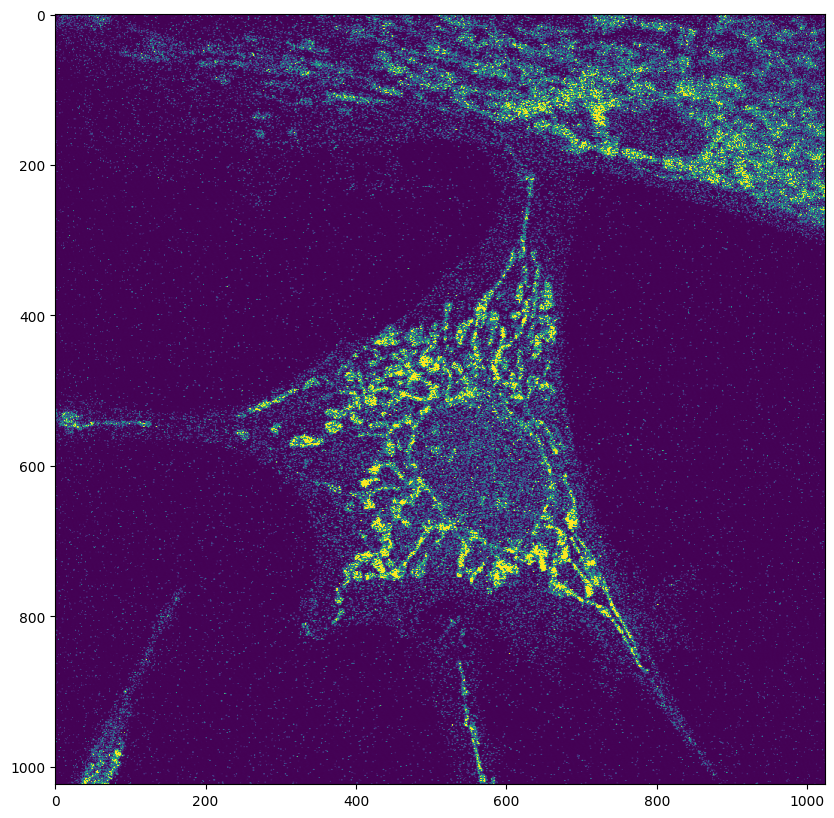

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(low_snr[0, 0], vmin=vmin, vmax=vmax)
plt.show()

Samples of pure noise are needed to estimate its spatial autocorrelation. Dark image patches with no signal are best for this. For this example dataset, we've collected a list of such patches. The more noise pixels used, the more accurate the estimate.

In [6]:
dark_patches = [low_snr[1, 0, 200:400, :300], low_snr[2, 0, :390, 650:], low_snr[5, 0, :200, :400], low_snr[6, 0, 300:400, :450]]

In [7]:
noise_ac = utils.autocorrelation(dark_patches, max_lag=25)

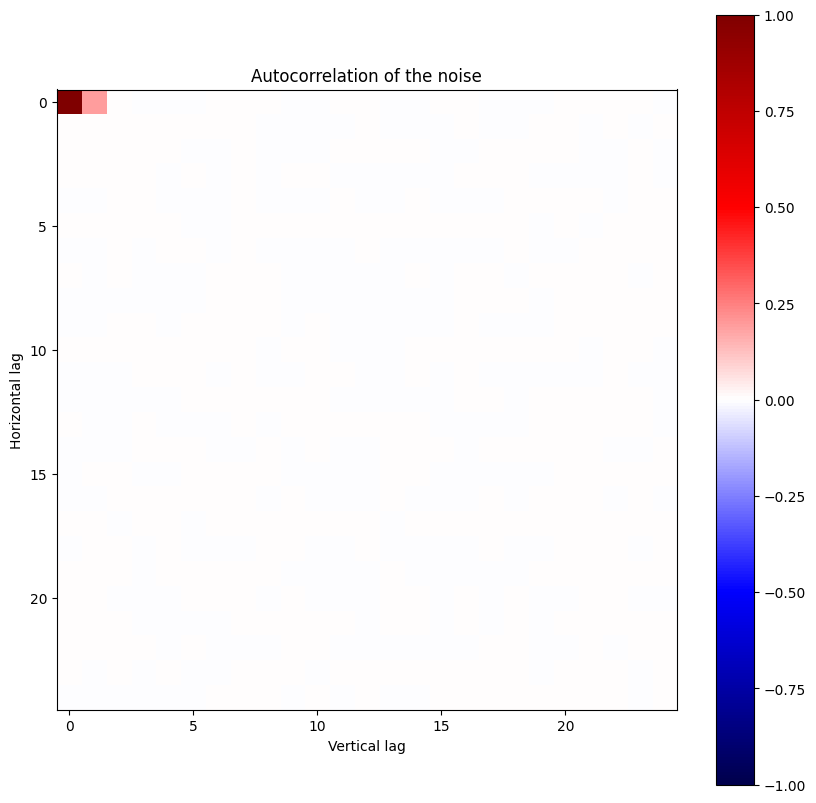

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(noise_ac, cmap="seismic", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Autocorrelation of the noise")
plt.xlabel("Vertical lag")
plt.ylabel("Horizontal lag")
plt.show()

The plot reveals a pattern of spatial correlation between noise pixels in the same row. To remove this, the autoregressive decoder of our VAE must have a receptive field spanning pixels in the same row. It is not necessary for it to span *all* correlated pixels, just enough to learn an accurate model. We found 40 pixels to work in all of our experiments, which is achieved by giving the decoder a kernel size of 5 and 4 layers.

## 3. Create training and validation dataloaders

The data will be fed to the model by two dataloaders, `train_loader` and `val_loader`, for the training and validation set respectively. <br>
In this example, 90% of images will be used for training and the remaining 10% for validation. This split has worked well with our model in most cases, but if the quantity of your data is limited, you might want to use a 80/20 split to get a larger validation set. 

Be careful with the choice of data augmentation. Operations such as rotating and mirroring will change the orientation of noise structures. Only use operations that won't affect the autocorrelation plotted above. In this example, we just use `transforms.RandomCrop`.

`batch_size` Number of images in a training batch. <br>
`crop_size` The size of randomly cropped patches. Should be less than the dimensions of your images.<br>
`train_split` Fraction of images to be used in the training set, with the remainder used for the validation set.


In [9]:
batch_size = 4
crop_size = 256
train_split = 0.9

n_iters = (low_snr[0].shape[-1] * low_snr[0].shape[-2]) // crop_size**2
transform = transforms.RandomCrop(crop_size)

low_snr = low_snr[torch.randperm(len(low_snr))]
train_set = low_snr[: int(len(low_snr) * train_split)]
val_set = low_snr[int(len(low_snr) * train_split) :]

train_set = utils.TrainDataset(train_set, n_iters=n_iters, transform=transform)
val_set = utils.TrainDataset(val_set, n_iters=n_iters, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, pin_memory=True
)

## 4. Create the models

`lvae` The ladder variational autoencoder that will output latent variables.<br>
* `s_code_channels` Number of channels in outputted latent variable.
* `n_layers` Number of levels in the hierarchical vae.
* `z_dims` List with the numer of latent space dimensions at each level of the hierarchy. List starts from the input/output level and works down.
* `downsampling` Whether to downsample at each level of the hierarchy. 1 for do and 0 for don't.

`ar_decoder` The autoregressive decoder that will decode latent variables into a distribution over the input.<br>
* `kernel_size` Length of 1D convolutional kernels.
* `RF_shape` Whether the receptive field should be oriented `"horizontal"` or `"vertical"`, to match the orientation of the noise.
* `n_filters` Number of feature channels.
* `n_gaussians` Number of components in Gaussian mixture used to model data.

`s_decoder` A decoder that will map the latnet variables into image space. <br>
* `n_filters` The number of feature channels.<br>

`direct_denoiser` The U-Net that can optionally be trained to predict the MMSE or MMAE of the denoised images. This will slow training slightly but massively speed up inference and is worthwile if you have an inference dataset in the gigabytes. See [this paper](https://arxiv.org/abs/2310.18116). Enable or disable the direct denoiser with `use_direct_denoiser`.
* `start_filters` Feature channels at first level of UNet. Doubles at subsequent layers.
* `kernel_size` Height and width of kernels.
* `depth` Depth of the U-Net.
* `loss_fn` Whether to use `"L1"` or `"L2"` loss function to predict either the mean or pixel-wise median of denoised images respectively.

`dvlae` The container that will unify and train the above models.
* `n_grad_batches` Number of batches to accumulate gradients for before updating weights of all models. If the batch or random crop size has been reduced to lower memory consumption, increase this value for the effective batch size to stay the same.

Note that some hyperparameters have been set to low values for reduced memory consumption. To use the full size model, use the value suggested in the inline comment.

In [10]:
s_code_channels = 32  # Set this to 128 to use the full size model

n_layers = 6  # Set this to 14 to use the full size model
z_dims = [s_code_channels // 2] * n_layers
downsampling = [1] * n_layers  # Set this to [0, 1] * (n_layers // 2) when using the full size model
lvae = LadderVAE(
    colour_channels=low_snr.shape[1],
    img_shape=(crop_size, crop_size),
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    z_dims=z_dims,
    downsampling=downsampling,
)

ar_decoder = PixelCNN(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    kernel_size=5,
    RF_shape="horizontal",
    n_filters=64,
    n_layers=4,
    n_gaussians=5,
)

s_decoder = SDecoder(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
)

use_direct_denoiser = True
if use_direct_denoiser:
    direct_denoiser = UNet(
        colour_channels=low_snr.shape[1],
        n_filters=s_code_channels,
        n_layers=n_layers,
        downsampling=downsampling,
        loss_fn="L2",
    )
else:
    direct_denoiser = None

dvlae = DVLAE(
    vae=lvae,
    ar_decoder=ar_decoder,
    s_decoder=s_decoder,
    direct_denoiser=direct_denoiser,
    data_mean=low_snr.mean(),
    data_std=low_snr.std(),
    n_grad_batches=4,
)

/home/ben/miniforge3/envs/cosdd/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vae' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae'])`.
/home/ben/miniforge3/envs/cosdd/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'ar_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['ar_decoder'])`.
/home/ben/miniforge3/envs/cosdd/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 's_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['s_decoder'])`.
/home/ben/miniforge3/envs/cosdd/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'direct_denoiser' is an i

## 5. Train the model

`model_name` should be set to something appropriate so that the trained parameters can be used later for inference.<br>
`max_epochs` The number of training epochs.<br>
`patience` If the validation loss has plateaued for this many epochs, training will stop.

Training logs can be monitored on Tensorboard. Run the three cells below to activate it in the notebook. Alternatively, open a terminal, activate an environment with Tensorboard installed and enter `tensorboard --logdir path/to/COSDD/checkpoints` then open a browser and enter localhost:6006.

In the SCALARS tab, there will be 4 metrics to track (5 if direct denoiser is enabled). These are:<br>
1. `kl_loss` The Kullback-Leibler divergence between the VAE's approximate posterior and its prior. This can be thought of as a measure of how much information about the input image is going into the VAE's latent variables. We want information about the input's underlying clean signal to go into the latent variables, so this metric shouldn't go all the way to zero. Instead, it can typically go either up or down during training before plateauing.<br>
2. `reconstruction_loss` The negative log-likelihood of the AR decoder's predicted distribution given the input data. This is how accurately the AR decoder is able to predict the input. This value can go below zero and should decrease throughout training before plateauing.<br>
3. `elbo` The Evidence Lower Bound, which is the total loss of the main VAE. This is the sum of the kl reconstruction loss and should decrease throughout training before plateauing.<br>
4. `sd_loss` The mean squared error between the noisy image and the image predicted by the signal decoder. This metric should steadily decrease towards zero without ever reaching it. Sometimes the loss will not go down for the first few epochs because its input (produced by the VAE) is rapidly changing. This is ok and the loss should start to decrease when the VAE stabilises. <br>
5. `dd_loss` The mean squared error between the output of the direct denoiser and the clean images predicted by the signal decoder. This will only be present if `use_direct_denoiser` is set to `True`. The metric should steadily decrease towards zero without ever reaching it, but may be unstable at the start of training as its targets (produced by the signal decoder) are rapidly changing.

There will also be an IMAGES tab. This shows noisy input images from the validation set and some outputs. These will be two randomly sampled denoised images (sample 1 and sample 2), the average of ten denoised images (mmse) and if the direct denoiser is enabled, its output (direct estimate).

If noise has not been fully removed from the output images, try increasing `n_gaussians` argument of the AR decoder. This will give it more flexibility to model complex noise characteristics. However, setting the value too high can lead to unstable training. Typically, values from 3 to 5 work best.

Note that the trainer is set to train for only 20 minutes in this example. Remove the line with `max_time` to train fully.

In [11]:
model_name = "mito-confocal"
checkpoint_path = os.path.join("checkpoints", model_name)
logger = TensorBoardLogger(checkpoint_path)

max_epochs = 1000
patience = 100

trainer = pl.Trainer(
    logger=logger,
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    max_epochs=max_epochs,
    max_time="00:00:20:00",  # Remove this time limit to train the model fully
    log_every_n_steps=len(train_set) // batch_size,
    callbacks=[EarlyStopping(patience=patience, monitor="val/elbo")],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
%load_ext tensorboard
%tensorboard --logdir checkpoints

In [13]:
trainer.fit(dvlae, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"))

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type      | Params
----------------------------------------------
0 | vae             | LadderVAE | 709 K 
1 | ar_decoder      | PixelCNN  | 195 K 
2 | s_decoder       | SDecoder  | 28.0 K
3 | direct_denoiser | UNet      | 558 K 
----------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.963     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ben/miniforge3/envs/cosdd/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


/home/ben/miniforge3/envs/cosdd/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Epoch 27:  67%|██████▋   | 189/284 [00:27<00:13,  6.93it/s, v_num=11]

Time limit reached. Elapsed time is 0:20:00. Signaling Trainer to stop.


Epoch 27:  67%|██████▋   | 190/284 [00:29<00:14,  6.43it/s, v_num=11]
